In [1]:
# Impoting required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# setting default option
pd.set_option("mode.copy_on_write", True)
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# loading the Datasets
mortality = pd.read_parquet("../../Data/processed/mortality_corrected.parquet")
shipment = pd.read_parquet("../../Data/processed/shipment_eda.parquet")

In [3]:
mortality.sample(5)

,State,State_Code,County,County_Code,Year,Deaths,Population,Mortality_Rate
4533,Louisiana,LA,RAPIDES,22079,2012,18,132022.0,0.000136
11263,Texas,TX,DALLAS,48113,2007,237,2291891.0,0.000103
7728,North Carolina,NC,HARNETT,37085,2006,10,103036.0,0.000097
1897,Florida,FL,OSCEOLA,12097,2015,48,323860.0,0.000148
9475,Oregon,OR,MARION,41047,2010,58,315948.0,0.000184


In [4]:
shipment.sample(5)

,BUYER_STATE,BUYER_COUNTY,YEAR,MME
2027,AZ,GILA,2007,2.946606e+07
19238,MO,DALLAS,2007,4.117147e+06
20280,MO,SULLIVAN,2012,2.478572e+06
36342,TX,KARNES,2009,2.088615e+06
40845,WI,ADAMS,2018,2.315569e+06


In [5]:
# Creating control variables

# Enter the Test State Below
test_state = "TX"

# Enter list of states required below, Included the test state
state_list = ["NM", "TX", "LA", "AR", "OK", "MS", "AL", "AZ"]

# Year control variable
policy_year = 2007  # year the policy was implemented
start_year = 2003  # desired start year for analysis
end_year = 2010  # desired end year for analysis

In [6]:
# subset the data
mortality = mortality[mortality["State_Code"].isin(state_list)]
mortality = mortality[
    (mortality["Year"] >= start_year) & (mortality["Year"] <= end_year)
]

In [7]:
# check number of times each county appears in the data
mortality["County_Code"].value_counts().value_counts()

count
8    177
Name: count, dtype: int64

In [8]:
# Add columns to tag the rows for pre-post policy implementation and test-control

# Tagging the rows for pre-post policy implementation
mortality["policy_implementation"] = mortality["Year"] >= policy_year

# Tagging the rows for test-control
mortality["State_Type"] = mortality["State_Code"].apply(
    lambda x: "Test" if x == test_state else "Control"
)

In [9]:
mortality.sample(5)

,State,State_Code,County,County_Code,Year,Deaths,Population,Mortality_Rate,policy_implementation,State_Type
9213,Oklahoma,OK,PAYNE,40119,2008,10,75000.0,0.000133,True,Control
11448,Texas,TX,HIDALGO,48215,2010,27,779091.0,0.000035,True,Test
11338,Texas,TX,GALVESTON,48167,2004,38,269760.0,0.000141,False,Test
11652,Texas,TX,PARKER,48367,2006,11,105387.0,0.000104,False,Test
195,Alabama,AL,LIMESTONE,01083,2003,7,68578.0,0.000102,False,Control


In [10]:
mortality_2 = (
    mortality.groupby(["State_Code", "Year", "policy_implementation"])
    .agg({"Mortality_Rate": "mean"})
    .reset_index()
)

In [11]:
mortality_2.sample(5)

,State_Code,Year,policy_implementation,Mortality_Rate
50,OK,2005,False,0.000137
58,TX,2005,False,0.000101
55,OK,2010,True,0.000201
16,AZ,2003,False,0.000117
27,LA,2006,False,0.000332


/Users/revanth/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(-6.359374999999991, 0.5, 'Mortality Rate Per-Capita')

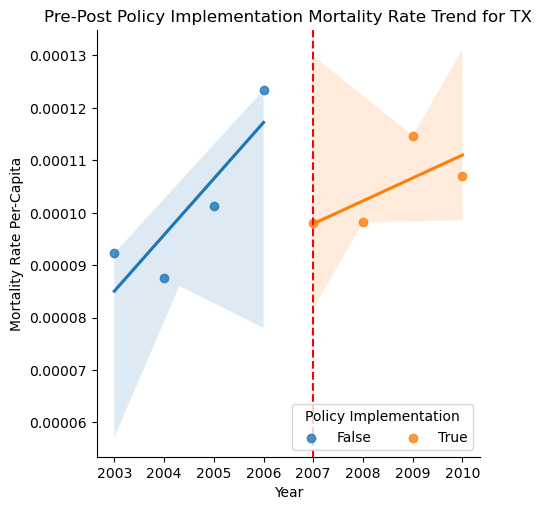

In [12]:
plot = sns.lmplot(
    data=mortality_2[mortality_2["State_Code"] == test_state],
    x="Year",
    y="Mortality_Rate",
    hue="policy_implementation",
    legend=False,
)
plot.set(title=f"Pre-Post Policy Implementation Mortality Rate Trend for {test_state}")

plt.legend(
    loc="lower right",
    # bbox_to_anchor=(0.5, -0.15),
    title="Policy Implementation",
    ncol=2,
)

ax = plot.axes[0, 0]

ax.axvline(policy_year, ls="--", color="red")
ax.set_ylabel("Mortality Rate Per-Capita")

/Users/revanth/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(2.515625000000009, 0.5, 'Mortality Rate Per-Capita')

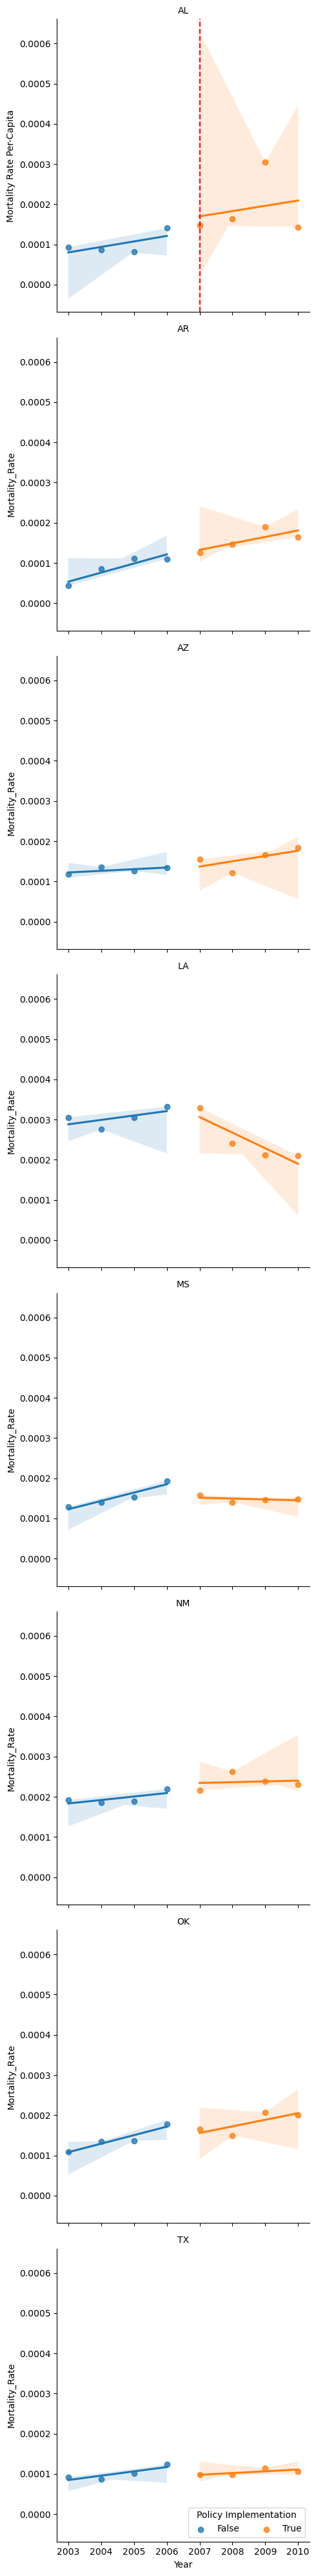

In [13]:
plot = sns.lmplot(
    data=mortality_2,
    x="Year",
    y="Mortality_Rate",
    hue="policy_implementation",
    legend=False,
    row="State_Code",
)

# Set titles for each subplot
plot = plot.set_titles("{row_name}")

plt.legend(
    loc="lower right",
    # bbox_to_anchor=(0.5, -0.15),
    title="Policy Implementation",
    ncol=2,
)

ax = plot.axes[0, 0]

ax.axvline(policy_year, ls="--", color="red")
ax.set_ylabel("Mortality Rate Per-Capita")

In [14]:
mortality_3 = (
    mortality.groupby(["State_Type", "Year", "policy_implementation"])
    .agg({"Mortality_Rate": "mean"})
    .reset_index()
)
mortality_3.sample(5)

,State_Type,Year,policy_implementation,Mortality_Rate
2,Control,2005,False,0.000163
1,Control,2004,False,0.000155
11,Test,2006,False,0.000123
15,Test,2010,True,0.000107
5,Control,2008,True,0.000180


In [15]:
mortality_3["hue_separator"] = (
    mortality_3["State_Type"]
    + " State-"
    + mortality_3["policy_implementation"].astype(str)
)

/Users/revanth/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(-6.359374999999991, 0.5, 'Mortality Rate Per-Capita')

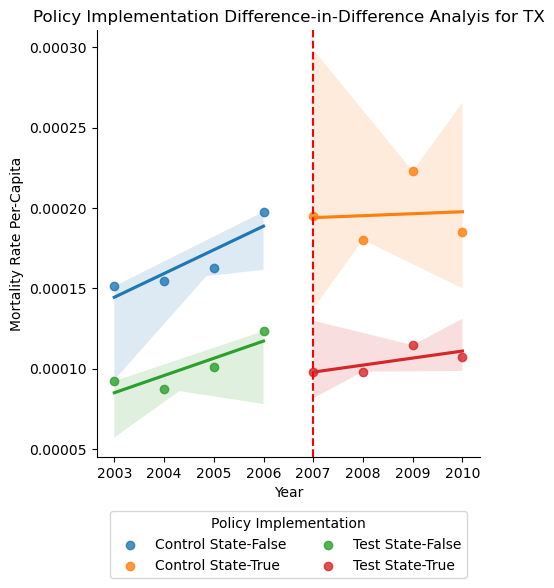

In [19]:
plot = sns.lmplot(
    data=mortality_3,
    x="Year",
    y="Mortality_Rate",
    hue="hue_separator",
    legend=False,
)
plot.set(
    title=f"Policy Implementation Difference-in-Difference Analyis for {test_state}"
)

plt.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.3),
    title="Policy Implementation",
    ncol=2,
)

ax = plot.axes[0, 0]

ax.axvline(policy_year, ls="--", color="red")
ax.set_ylabel("Mortality Rate Per-Capita")